# Rethinking Statistics course in Numpyro - Week 4

Lecture 7: Ulysses' Compass

- [Video](https://www.youtube.com/watch?v=0Jc6Kgw5qc0)
- [Slides](https://speakerdeck.com/rmcelreath/l07-statistical-rethinking-winter-2019)

Lecture 8: Model Comparison

- [Video](https://youtu.be/gjrsYDJbRh0)
- [Slides](https://speakerdeck.com/rmcelreath/l08-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week04.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week04_solutions.pdf) for the exercises of the week.

In [1]:
import numpy as np
import pandas as pd

from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC,NUTS,Predictive

import arviz as az
import seaborn as sns

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Mar 28 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.21.0

arviz  : 0.11.2
numpyro: 0.6.0
pandas : 1.2.3
numpy  : 1.20.1
seaborn: 0.11.1
jax    : 0.2.10

Watermark: 2.2.0



In [3]:
sns.set_style('whitegrid')
rng_key = random.PRNGKey(0)

## Exercise 1

> Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the birb population. They have each found the following proportions of 5 important birb species:

| island | bird A | bird B | bird C | bird D | bird E |
|--|--|--|--|--|--|
| Island 1 | 0.2 | 0.2 | 0.2  | 0.2   |0.2|
| Island 2 | 0.8 | 0.1 | 0.05 | 0.025 | 0.025|
| Island 3 | 0.05 | 0.15 | 0.7  | 0.05  | 0.05|

> Notice that each row sums to 1, all the birbs. This problem has two parts. It is not computationally complicated. But it is conceptually tricky.
First, compute the entropy of each island's birb distribution. Interpret these entropy values.

> Second, use each island's birb distribution to predict the other two. This means to compute the K-L Divergence of each island from the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different K-L Divergence values. Which island predicts the others best? Why?

In [4]:
data = [['Island 1', 0.2, 0.2, 0.2, 0.2, 0.2], ['Island 2', 0.8, 0.1, 0.05, 0.025, 0.025], ['Island 3', 0.05, 0.15, 0.7, 0.05, 0.05]] 
df = pd.DataFrame(data, columns = ['Island', 'Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E'])
df

,Island,Bird A,Bird B,Bird C,Bird D,Bird E
0,Island 1,0.20,0.20,0.20,0.200,0.200
1,Island 2,0.80,0.10,0.05,0.025,0.025
2,Island 3,0.05,0.15,0.70,0.050,0.050


The first island has the largest entropy, followed by the third, and then the second in last place. Why is this? Entropy is a measure of the evenness of a distribution. The first islands has the most even distribution of birbs. This means you wouldn’t be very surprised by any particular birb. The second island, in contrast, has a very uneven distribution of birbs. If you saw any birb other than the first species, it would be surprising.

In [5]:
cols = df.columns[1:6]
df['entropy']= -(df[cols]*np.log(df[cols])).sum(axis=1)
df

,Island,Bird A,Bird B,Bird C,Bird D,Bird E,entropy
0,Island 1,0.20,0.20,0.20,0.200,0.200,1.609438
1,Island 2,0.80,0.10,0.05,0.025,0.025,0.743004
2,Island 3,0.05,0.15,0.70,0.050,0.050,0.983600


 Now we need K-L distance, so let’s write a function for it. This is the distance from q to p, regarding p as true and q as the model. Now to use each island as a model of the others, we need to consider the different ordered pairings. The way to read this is each column as a model and each row as a true distribution. So the first island, the first column, the one named `entropy_model1`, has the smaller distances to the other islands. Why does that give it a shorter distance to the other islands? Because it is less surprised by the other islands, due to its high entropy. This makes sense, since it has the highest entropy.

In [6]:
for i in range(3):
    df[f'entropy_model_{i+1}']= (df[cols]*(np.log(df[cols]) - np.log(df[cols]).loc[i,])).sum(axis=1)
df

,Island,Bird A,Bird B,Bird C,Bird D,Bird E,entropy,entropy_model_1,entropy_model_2,entropy_model_3
0,Island 1,0.20,0.20,0.20,0.200,0.200,1.609438,0.000000,0.970406,0.638760
1,Island 2,0.80,0.10,0.05,0.025,0.025,0.743004,0.866434,0.000000,2.010914
2,Island 3,0.05,0.15,0.70,0.050,0.050,0.983600,0.625838,1.838845,0.000000


## Exercise 2

> Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again. Compare these two models using WAIC (or LOO, they will produce identical results). Which model is expected to make better predictions? Which model provides the correct causal inference about the influence of age on happiness? Can you explain why the answers to these two questions disagree?

We start as always getting and processing the data:

In [7]:
d = pd.read_csv('./dat/happiness.csv', header=0)
d.tail(3)

,age,married,happiness
1297,1,0,1.578947
1298,1,0,1.789474
1299,1,0,2.000000


In [8]:
d = d.loc[d.age > 17,]
d['age'] = ( d['age'] - 18 ) / ( 65 - 18 )
d['married'] = d['married'].astype('Int64')
d.tail(3)

,age,married,happiness
957,0.0,0,1.578947
958,0.0,0,1.789474
959,0.0,0,2.000000


Model 6.9 from the book:

In [9]:
def model(age, happiness=None):
    # priors
    n = len(d.married.unique())
    a = numpyro.sample('a', dist.Normal(0,1), sample_shape=(n,))
    bA = numpyro.sample('bA', dist.Normal(0,2))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    ix = pd.Categorical(d.married, categories=[0,1]).codes
    mu = a[ix] + bA*age
    numpyro.sample('happy_hat', dist.Normal(mu,sigma), obs=happiness)

In [10]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, age=d.age.values, happiness=d.happiness.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 417.45it/s, 7 steps of size 4.00e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.24      0.06     -0.23     -0.34     -0.13    850.13      1.00
      a[1]      1.26      0.08      1.26      1.10      1.38   1007.99      1.00
        bA     -0.75      0.11     -0.75     -0.94     -0.58    915.53      1.00
     sigma      0.99      0.02      0.99      0.96      1.03   1388.50      1.00

Number of divergences: 0


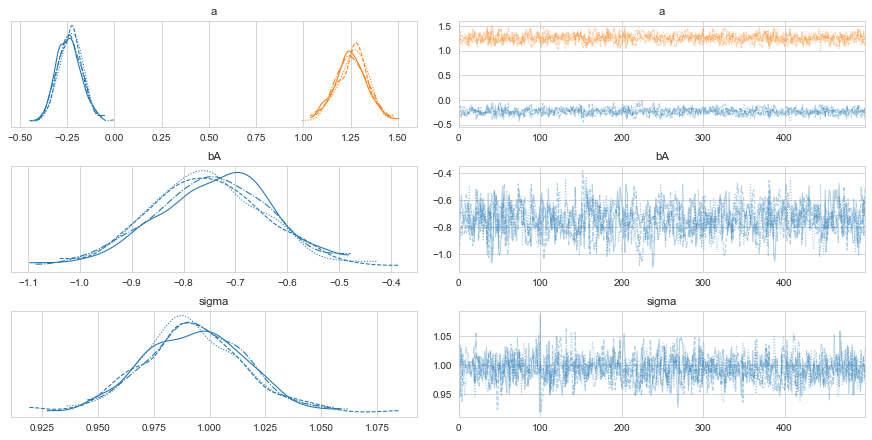

In [11]:
samples_69 = az.from_numpyro(mcmc)
az.plot_trace(samples_69);

Model 6.10 from the book:

In [12]:
def model(age, happiness=None):
    # priors
    a = numpyro.sample('a', dist.Normal(0,1))
    bA = numpyro.sample('bA', dist.Normal(0,2))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + bA*age
    numpyro.sample('happy_hat', dist.Normal(mu,sigma), obs=happiness)

In [13]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, age=d.age.values, happiness=d.happiness.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 422.44it/s, 15 steps of size 4.52e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.08     -0.00     -0.13      0.13    732.61      1.01
        bA      0.00      0.14      0.00     -0.20      0.25    702.93      1.01
     sigma      1.22      0.03      1.21      1.17      1.26   1137.84      1.00

Number of divergences: 0


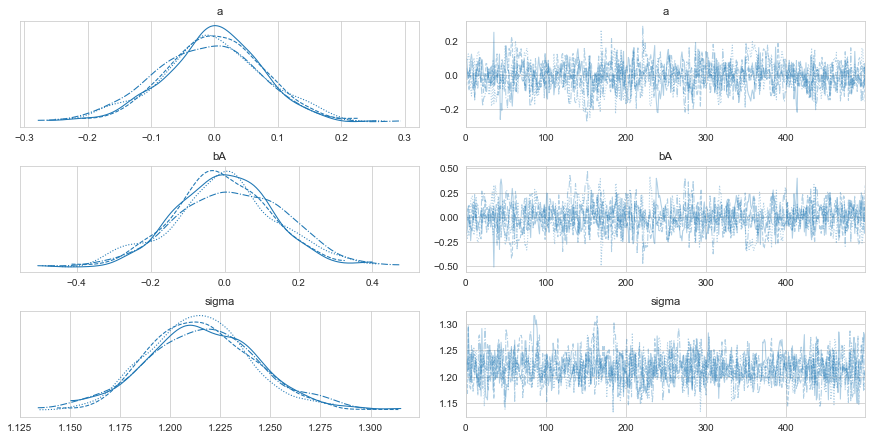

In [14]:
samples_610 = az.from_numpyro(mcmc)
az.plot_trace(samples_610);

I won't repeat the models here. They are in the text (_I just did both_). Model m6.9 contains both marriage status and age. Model m6.10 contains only age. Model m6.9 produces a confounded inference about the relationship between age and happiness, due to opening a collider path. To compare these models using WAIC:

In [15]:
az.compare({'model_69': samples_69, 'model_610': samples_610}, scale='deviance')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_69,0,2713.492624,3.466304,0.000000,0.994326,37.232089,0.000000,False,deviance
model_610,1,3102.134039,2.457632,388.641415,0.005674,27.629848,35.079137,False,deviance


The model that produces the invalid inference, m6.9, is expected to predict much better. And it would. This is because the collider path does convey actual association. We simply end up mistaken about the causal inference. We should not use WAIC (or LOO) to choose among models, unless we have some clear sense of the causal model. These criteria will happily favor confounded models.

## Exercise 3

> Reconsider the urban fox analysis from last week's homework. Use WAIC or LOO based model comparison on five different models, each using `weight` as the outcome, and containing these sets of predictor variables:

>1. `avgfood` + `groupsize` + `area`
2. `avgfood` + `groupsize`
3. `groupsize` + `area`
4. `avgfood`
5. `area`

In [16]:
d = pd.read_csv('./dat/foxes.csv', sep=';', header=0)
d.tail(3)

,group,avgfood,groupsize,area,weight
113,30,0.41,3,1.91,3.16
114,30,0.41,3,1.91,2.78
115,30,0.41,3,1.91,3.86


Standarise the data first of all:

In [17]:
cols = ['avgfood','groupsize','area','weight']
d[cols] = (d[cols] - d[cols].mean())/d[cols].std()
d.tail(3)

,group,avgfood,groupsize,area,weight
113,30,-1.723131,-0.87411,-1.356312,-1.156781
114,30,-1.723131,-0.87411,-1.356312,-1.477721
115,30,-1.723131,-0.87411,-1.356312,-0.565576


Models

In [18]:
def model(avgfood, groupsize, area, weight=None):
    # priors
    a = numpyro.sample('alpha', dist.Normal(0,0.2))
    b = numpyro.sample('beta', dist.Normal(0,0.5), sample_shape=(3,))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + b[0]*avgfood + b[1]*groupsize + b[2]*area
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['avgfood', 'groupsize', 'area', 'weight']].items()}
mcmc.run(rng_key, **dat)
samples_1 = az.from_numpyro(mcmc)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 406.70it/s, 7 steps of size 3.58e-01. acc. prob=0.89]


In [19]:
def model(avgfood, groupsize, weight=None):
    # priors
    a = numpyro.sample('alpha', dist.Normal(0,2))
    b = numpyro.sample('beta', dist.Normal(0,0.5), sample_shape=(2,))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + b[0]*avgfood + b[1]*groupsize
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['avgfood', 'groupsize', 'weight']].items()}
mcmc.run(rng_key, **dat)
samples_2 = az.from_numpyro(mcmc)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 406.36it/s, 15 steps of size 3.51e-01. acc. prob=0.91]


In [20]:
def model(groupsize, area, weight=None):
    # priors
    a = numpyro.sample('alpha', dist.Normal(0,2))
    b = numpyro.sample('beta', dist.Normal(0,0.5), sample_shape=(2,))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + b[0]*groupsize + b[1]*area
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['area', 'groupsize', 'weight']].items()}
mcmc.run(rng_key, **dat)
samples_3 = az.from_numpyro(mcmc)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 352.09it/s, 7 steps of size 4.53e-01. acc. prob=0.91]


In [21]:
def model(avgfood, weight=None):
    # priors
    a = numpyro.sample('alpha', dist.Normal(0,2))
    b = numpyro.sample('beta', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + b*avgfood
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, avgfood=d.avgfood.values, weight=d.weight.values)
samples_4 = az.from_numpyro(mcmc)

sample: 100%|██████████| 1000/1000 [00:02<00:00, 359.33it/s, 3 steps of size 8.63e-01. acc. prob=0.89]


In [22]:
def model(area, weight=None):
    # priors
    a = numpyro.sample('alpha', dist.Normal(0,2))
    b = numpyro.sample('beta', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + b*area
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, area=d.area.values, weight=d.weight.values)
samples_5 = az.from_numpyro(mcmc)

sample: 100%|██████████| 1000/1000 [00:03<00:00, 298.41it/s, 7 steps of size 8.39e-01. acc. prob=0.89]


In [23]:
az.compare({'model_1': samples_1,
            'model_2': samples_2,
            'model_3': samples_3,
            'model_4': samples_4,
            'model_5': samples_5}, scale='deviance')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_1,0,322.817949,4.506003,0.000000,0.000000e+00,15.530169,0.000000,False,deviance
model_2,1,323.706171,3.485549,0.888222,5.127079e-01,15.286721,3.286075,False,deviance
model_3,2,323.773509,3.577301,0.955560,4.872921e-01,15.050174,2.895080,False,deviance
model_4,3,333.603751,2.452978,10.785802,8.285153e-16,13.383456,6.820537,False,deviance
model_5,4,333.883797,2.676696,11.065847,0.000000e+00,13.320121,6.878447,False,deviance


The variables of the models were the following ones:
1. `avgfood` + `groupsize` + `area`
2. `avgfood` + `groupsize`
3. `groupsize` + `area`
4. `avgfood`
5. `area`

To remind you, the DAG from last week is:

<img src="./fig/w1_img1.png" width="60%">

Notice that the top three models are m1, m3, and m2. They have very similar WAIC values. The differences are small and smaller in all cases than the standard error of the difference. WAIC sees these models are tied. This makes sense, given the DAG, because as long as a model has `groupsize` in it, we can include either `avgfood` or `area` or both and get the same inferences. Another way to think of this is that the influence of good, adjusting for `groupsize`, is (according to the DAG) the same as the influence of `area`, adjusting for `groupsize`, because the influence of `area` is routed entirely through `avgfood` and `groupsize`. There are no back-door paths.

What about the other two models, m4 and m5? These models are tied with one another, and both omit `groupsize`. Again, the influence of `area` passes entirely through `avgfood`. So including only `avgfood` or only `area` should produce the same inference; the total causal influence of `area` (or `avgfood`) is just about zero. That's indeed what the posterior distributions suggest:

In [24]:
az.summary(samples_4, hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.09,-0.14,0.15,0.0,0.0,1774.0,1782.0,1.0
beta,-0.02,0.09,-0.17,0.12,0.0,0.0,2062.0,1439.0,1.0
sigma,1.01,0.07,0.90,1.11,0.0,0.0,2318.0,1709.0,1.0


In [25]:
az.summary(samples_5, hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.09,-0.14,0.14,0.0,0.0,1774.0,1535.0,1.0
beta,0.02,0.10,-0.12,0.19,0.0,0.0,2348.0,1512.0,1.0
sigma,1.01,0.07,0.91,1.11,0.0,0.0,1927.0,1456.0,1.0
